전이학습

https://keras.io/api/applications/


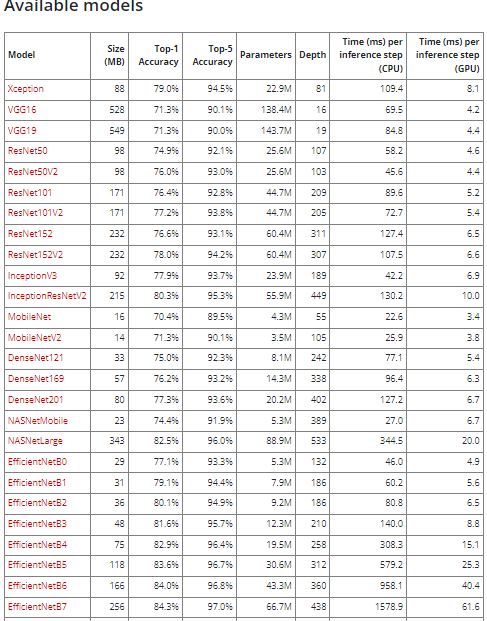

VGG, Incepton,ResNet
  - VGG : 3x3의 작은 마스크 이용
  - Inception(GoogleNet): 네트웍에 작은 네트웍
   - ResNet : 잔류 학습

   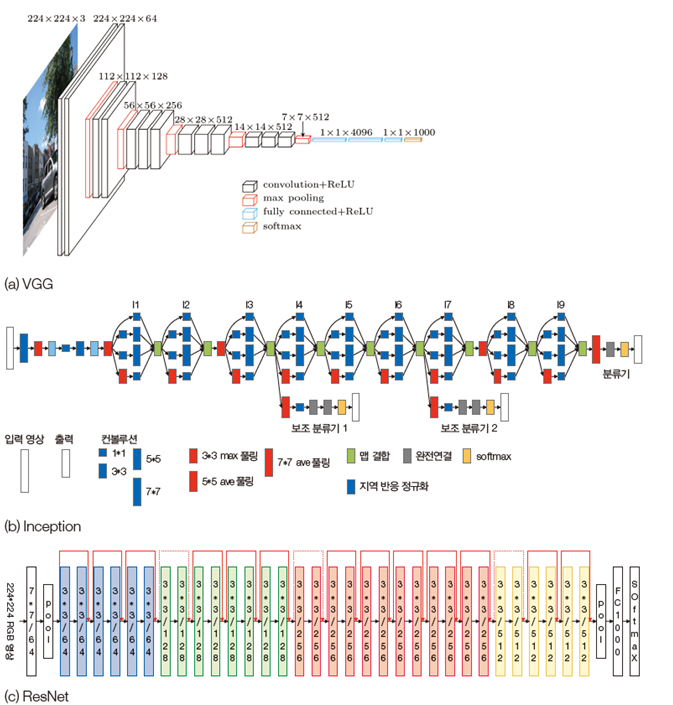

ImageNet 으로 학습한 ResNet 모델을 새 품종(cub 데이터셋)을 인식하는 문제로 전이


In [2]:
!unzip /content/drive/MyDrive/CUB200.zip -d ./cube200/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./cube200/train/039.Least_Flycatcher/Least_Flycatcher_0046_30316.jpg  
  inflating: ./cube200/train/039.Least_Flycatcher/Least_Flycatcher_0047_30393.jpg  
  inflating: ./cube200/train/039.Least_Flycatcher/Least_Flycatcher_0052_30321.jpg  
  inflating: ./cube200/train/039.Least_Flycatcher/Least_Flycatcher_0058_30143.jpg  
  inflating: ./cube200/train/039.Least_Flycatcher/Least_Flycatcher_0061_30429.jpg  
  inflating: ./cube200/train/039.Least_Flycatcher/Least_Flycatcher_0063_30190.jpg  
  inflating: ./cube200/train/039.Least_Flycatcher/Least_Flycatcher_0070_30147.jpg  
  inflating: ./cube200/train/039.Least_Flycatcher/Least_Flycatcher_0075_30441.jpg  
  inflating: ./cube200/train/039.Least_Flycatcher/Least_Flycatcher_0077_30296.jpg  
  inflating: ./cube200/train/039.Least_Flycatcher/Least_Flycatcher_0081_30380.jpg  
  inflating: ./cube200/train/039.Least_Flycatcher/Least_Flycatcher_0082_30132.jpg  
  inflating: ./cube200/train/039.Least_F

In [3]:
train_folder = './cube200/train'
test_folder = './cube200/test'

In [4]:
import os
import tensorflow as tf
import numpy as np

In [ ]:
# 전이학습사용할때는, 전이학습 모델, 해당모델에 맞게 데이터를 변경해주는 라이브러리
image = tf.keras.preprocessing.image
ResNet50 = tf.keras.applications.resnet50.ResNet50
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [37]:
class_reduce = 0.1  #메모리 문제로인해 일부 데이터만 사용
no_class = int(len(os.listdir(train_folder))*class_reduce)

def convertImgToArray(img_path,img_size):
  train,target = [],[]
  for i, class_name in  enumerate(os.listdir(img_path)):  # 폴더
    if i < no_class: # 위에서 줄인 개수만큼만 사용
      for fname in os.listdir(img_path +'/'+class_name):  # 폴더내의 이미지파일
        img = image.load_img(img_path +'/'+class_name+'/'+fname, target_size=(img_size,img_size))
        if len(img.getbands()) != 3:
          print(f"image error : {class_name}, {fname}")
          continue
        x = image.img_to_array(img)
        x = preprocess_input(x)
        train.append(x)
        target.append(i)
  return np.asarray(train),np.asarray(target)

In [38]:
# x_train,y_train = convertImgToArray(train_folder,224)
# x_test,y_test = convertImgToArray(test_folder,224)
x_train,y_train = convertImgToArray(train_folder,600)
x_test,y_test = convertImgToArray(test_folder,600)

In [39]:
x_train.shape, x_test.shape

((600, 600, 600, 3), (551, 600, 600, 3))

In [40]:
y_train = tf.keras.utils.to_categorical(y_train,no_class)
y_test = tf.keras.utils.to_categorical(y_test,no_class)
y_train.shape, y_test.shape

((600, 20), (551, 20))

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
# EfficientNetB7
EfficientNetB7 = tf.keras.applications.EfficientNetB7
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
base_model = EfficientNetB7(include_top=False, input_shape=(600,600,3) )


# base_model = ResNet50(include_top=False, input_shape=(224,224,3) )




258076736/258076736 [==============================] - 12s 0us/step


In [42]:
x = tf.keras.layers.Flatten()(base_model.output)
regularizers = tf.keras.regularizers
x = tf.keras.layers.Dense(1024,activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(no_class,activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.inputs, outputs = outputs)

In [29]:
# model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # 미세조정방식
              loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
generator = ImageDataGenerator(rotation_range=3.0,width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True)
# gen = generator.flow(x_train,y_train,batch_size=32)
hist = model.fit(x_train,y_train,batch_size=16,epochs=10,validation_data=(x_train,y_train))

Epoch 1/10


In [32]:
model.evaluate(x_test,y_test)

18/18 [==============================] - 0s 20ms/step - loss: 18.3518 - accuracy: 0.8421


[18.351829528808594, 0.8421052694320679]

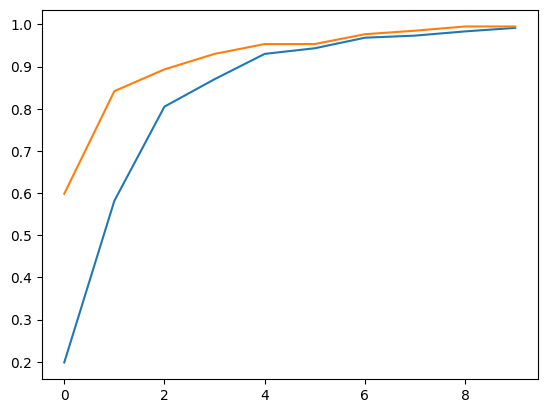

In [33]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.show()

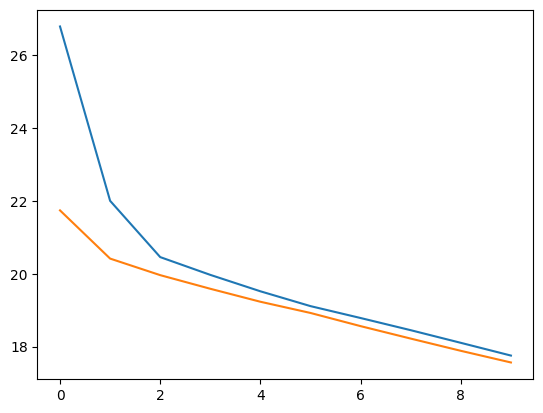

In [34]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()